# Charge profile optimization - M2

Ref: Hoke 2011 [Electric Vehicle Charge Optimization Including
Effects of Lithium-Ion Battery Degradation]

Here we include a constant cost of charging, as a quadratic function of the charge power in both direction (G2V and V2G).
The optimization task is nonlinear and we therefore depart from Google's OR-Tools to use scipy optimize function.

Model 1:
- An electric vehicle (EV) can charge within a time window (t_min;t_max), from a charge infrastructure with varying electricity prices.

Model 2:
- Both V2G and G2V charges are allowed: the EV acts as a battery that helps balance offer and demand.
- However, charging degrades the battery, and this is accounted by an Arrhenius relationship inspired from Hoke 2011, here with arbitrary parameters.

Key observations:
- V2G charge occurs at higher electricity prices, while G2V occurs at lower prices. This behavior has economic interests for the consumer, and would help balance the grid demand and offer if the electricity prices translate (as they should).
- The higher degradation encountered at higher power charges is captured here (although with arbitrary parameters): as higher charges are associated with increase in temperature and thus increased battery degradation, charge profile occur at a constant power on periods of constant electricity prices (e.g. two consecutive 3kWh charges are preferred to one 6kWh charge and one null charge). Without this effect, for instance with a degradation linear to the power charge, charge powers are herratic (not shown here). 

Next in Model 3: battery degradation at higher State of Charge will be accounted for.

In [1]:
import numpy as np
import scipy
import seaborn as sns; sns.set_style("whitegrid");

In [2]:
# Electricity market

TIME_PERIOD_HOURS = 24 # starts at noon=0
# Costs based on approximation of EDF's "Tarif Bleu", august 2020 (https://www.jechange.fr/energie/electricite/guides/prix-electricite-kwh-2435)
LOW_COST = 0.1377
HIGH_COST = 0.1781
ELECTRICITY_COSTS = [LOW_COST]*5 + [HIGH_COST]*4 + [LOW_COST]*10 + [HIGH_COST]*5  # 12h-17h, 17h-21h, 21h-7h, 7H-12h

# Vehicle

STATE_OF_CHARGE_T0 = 0.30
STATE_OF_CHARGE_TCH = 0.90
Q_KWH = 30
BATTERY_COST = Q_KWH*156*0.84 # euros
# based on 2019 average price as reported in 
# https://about.bnef.com/blog/battery-pack-prices-fall-as-market-ramps-up-with-market-average-at-156-kwh-in-2019/

# Charge system

CHARGE_POWER_LOWER_BOUND_KWH = -6.6
CHARGE_POWER_HIGHER_BOUND_KWH = 6.6

def degradation_function(p_):
    # degradation is expressed as ratio of total battery lifecycle reduction.
    # Form of the function is borrowed from Hoke 2011, with the approximation that temperature would rise
    # with higher power charge. The actual environment temperature is considered constant here, and allow charge
    # related temperature increase is considered. Parameters a and b are arbitrary.
    return (10**-5)*(np.exp(0.05*abs(p_)/CHARGE_POWER_HIGHER_BOUND_KWH))

# DEGRADATION_BY_KWH = 0
# User
T_MIN = 1 # vehicle is plugged
T_MAX = 22  # Vehicle to be charged before 7am

[Text(0.5, 0, 'Time (hours, 0=noon)'),
 Text(0, 0.5, 'Electricity price (euros)')]

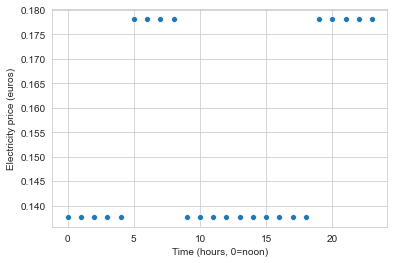

In [3]:
ax = sns.scatterplot(range(24), ELECTRICITY_COSTS)
ax.set(xlabel='Time (hours, 0=noon)', ylabel='Electricity price (euros)')

In [4]:
# Define the objective function
def cost_electricity(p):
    return sum(p_*ep for p_,ep in zip(p, ELECTRICITY_COSTS))
def cost_degradation(p):
    return BATTERY_COST*sum(degradation_function(p_) for p_ in p)
def cost_charge(p):
    ce = cost_electricity(p)
    cd = cost_degradation(p)
    return ce + cd

# Define bounds constraints
from scipy.optimize import Bounds
lb = [0]*T_MIN + [CHARGE_POWER_LOWER_BOUND_KWH]*(T_MAX-T_MIN) + [0]*(24-T_MAX)
ub = [0]*T_MIN + [CHARGE_POWER_HIGHER_BOUND_KWH]*(T_MAX-T_MIN) + [0]*(24-T_MAX)

bounds = Bounds(lb, ub)

# Define linear constraints for the charge up to t to be within [0, Q], and to be at least at desired SOC at T_MAX.
from scipy.optimize import LinearConstraint
m = np.tril([1]*24).reshape((24,24))
lb = np.ones((24,))*(-STATE_OF_CHARGE_T0*Q_KWH)
lb[T_MAX:] = (STATE_OF_CHARGE_TCH-STATE_OF_CHARGE_T0)*Q_KWH
ub = np.ones((24,))*((1-STATE_OF_CHARGE_T0)*Q_KWH)
linear_constraint = LinearConstraint(m.tolist(), lb, ub)

In [5]:
# solving the problem
from scipy.optimize import minimize
p0 = [1]*24
res = minimize(cost_charge, p0, method='trust-constr', constraints=[linear_constraint],
               options={'verbose': 1}, bounds=bounds)

`gtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 775, CG iterations: 81, optimality: 9.44e-09, constraint violation: 1.60e-13, execution time: 0.57 s.


Optimal charge profile (kWh):
[0.0, 4.35, 4.36, 4.35, 4.35, -6.6, -6.6, -6.6, -6.6, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, -1.01, -1.0, -1.0, -0.0, 0.0]
Resulting vehicle charge (kWh)
[9.000e+00 1.335e+01 1.771e+01 2.206e+01 2.641e+01 1.981e+01 1.321e+01
 6.610e+00 1.000e-02 3.010e+00 6.010e+00 9.010e+00 1.201e+01 1.501e+01
 1.801e+01 2.101e+01 2.401e+01 2.701e+01 3.001e+01 2.900e+01 2.800e+01
 2.700e+01 2.700e+01 2.700e+01]
Total balance of grid = 2.3 € (electricity = 1.3 €, degradation = 1.0 €)


[Text(0.5, 0, 'Time (hours, 0=noon)'),
 Text(0, 0.5, 'Power charge (kWh)'),
 Text(0.5, 1.0, 'Optimal charge profile')]

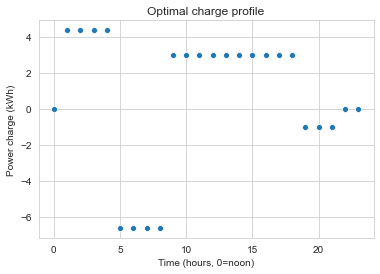

In [6]:
print('Optimal charge profile (kWh):')
solution = [round(rx,2) for rx in res.x]
print(solution)
print('Resulting vehicle charge (kWh)')
print(np.cumsum(solution) + Q_KWH*STATE_OF_CHARGE_T0)
print('Total balance of grid = {} € (electricity = {} €, degradation = {} €)'.format(round(cost_charge(res.x), 1),
                                                                            round(cost_electricity(res.x), 1),
                                                                            round(cost_degradation(res.x), 1)))
ax = sns.scatterplot(range(24), res.x)
ax.set(xlabel='Time (hours, 0=noon)', ylabel='Power charge (kWh)', title="Optimal charge profile")